In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import time
import tensorflow

In [ ]:
from numpy.random import seed
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM
from tensorflow.keras.callbacks import EarlyStopping
from pylab import rcParams

In [ ]:
dfoil = pd.read_csv('dfoil.csv',index_col=0,parse_dates=True)

In [ ]:
freq_time = 'M'
nobs = 12

n_input = 12
batchsize = 1

#RNN
LSTM_neurons = 20
activation_fct = 'relu'
n_features_oil = len(dfoil.columns)
n_epochs = 30


In [ ]:
dfoil = dfoil.resample(freq_time).mean()
dfoil.index.freq = freq_time

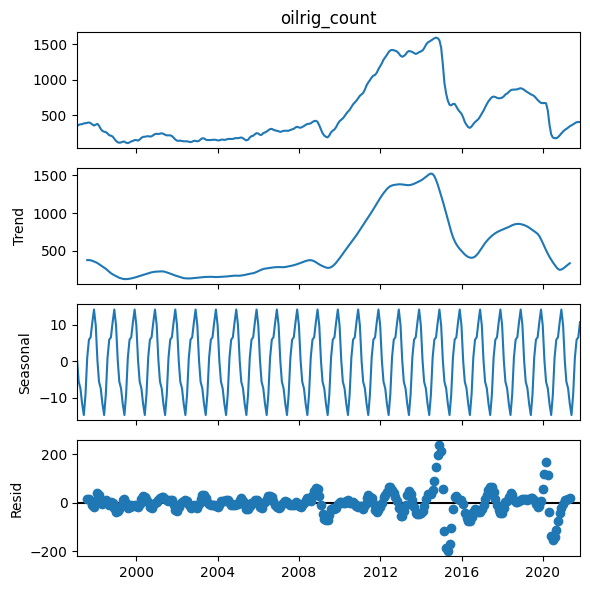

In [ ]:
results = seasonal_decompose(dfoil['oilrig_count'])
results.plot();

<Axes: >

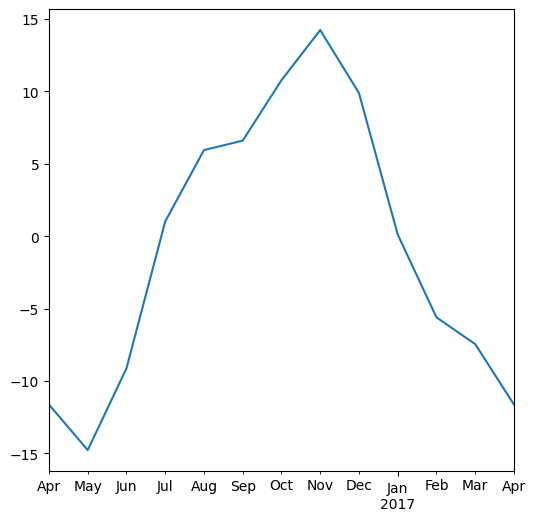

In [ ]:
results.seasonal.loc['2016-04':'2017-04'].plot()

In [ ]:
train_oil = dfoil.iloc[:len(dfoil)-nobs]
test_oil = dfoil.iloc[len(dfoil)-nobs:]

In [ ]:
scaler_oil = MinMaxScaler()
scaler_oil.fit(train_oil)
train_oil_transformed = scaler_oil.transform(train_oil)
test_oil_transformed = scaler_oil.transform(test_oil)

In [ ]:
earlystop = EarlyStopping(monitor='val_loss',patience=1)

In [ ]:
generator_oil = TimeseriesGenerator(data=train_oil_transformed,
                                    targets=train_oil_transformed,
                                    length = n_input,
                                    batch_size= batchsize
                                    )

In [ ]:
X,Y = generator_oil[0]

In [ ]:
X.shape

(1, 12, 5)

In [ ]:
Y

array([[0.18225107, 0.04411543, 0.55608499, 0.26622101, 0.1209207 ]])

In [ ]:
model_oil = Sequential()
model_oil.add(LSTM(LSTM_neurons, activation=activation_fct, input_shape=(n_input, n_features_oil)))
model_oil.add(Dense(10, activation=activation_fct))
model_oil.add(Dense(n_features_oil))
model_oil.compile(optimizer='adam', loss='mse')
model_oil.fit_generator(generator_oil, epochs=n_epochs, validation_data=generator_oil, callbacks=[earlystop])


Epoch 1/30
274/274 [==============================] - 11s 32ms/step - loss: 0.0707 - val_loss: 0.0181
Epoch 2/30
274/274 [==============================] - 5s 18ms/step - loss: 0.0147 - val_loss: 0.0099
Epoch 3/30
274/274 [==============================] - 6s 21ms/step - loss: 0.0095 - val_loss: 0.0083
Epoch 4/30
274/274 [==============================] - 5s 18ms/step - loss: 0.0071 - val_loss: 0.0057
Epoch 5/30
274/274 [==============================] - 5s 20ms/step - loss: 0.0062 - val_loss: 0.0080


In [ ]:
model_oil.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 20)                2080      
                                                                 
 dense_2 (Dense)             (None, 10)                210       
                                                                 
 dense_3 (Dense)             (None, 5)                 55        
                                                                 
Total params: 2345 (9.16 KB)
Trainable params: 2345 (9.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


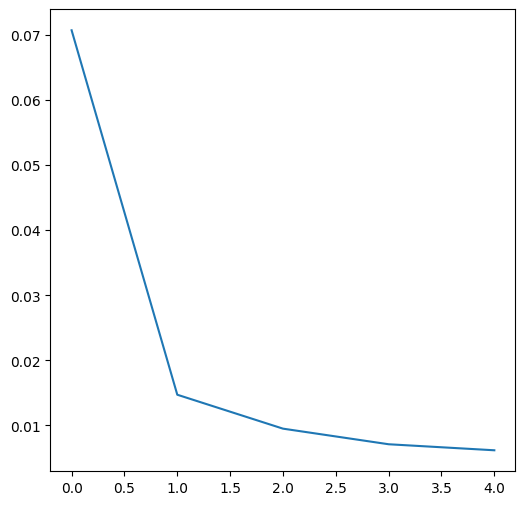

In [ ]:
plt.plot(range(len(model_oil.history.history['loss'])),model_oil.history.history['loss'])


<Axes: >

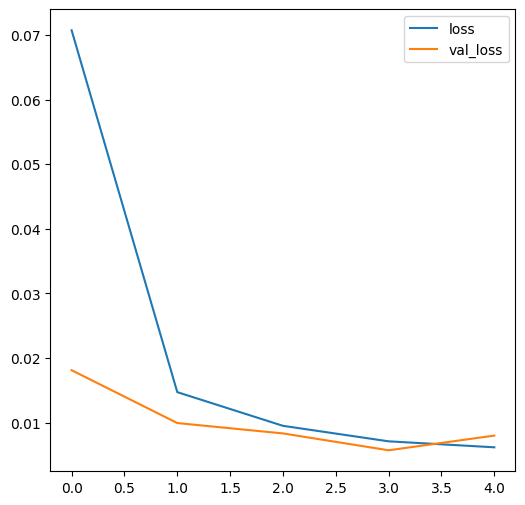

In [ ]:
losses = pd.DataFrame(model_oil.history.history)
losses.plot()

In [ ]:
testoil_predictions = [] #store the predictions
evalbatch_oil = train_oil_transformed[-n_input:] #last observations (nobs) from the train set used to make the first prediction
print(f'Before Reshape:\n {evalbatch_oil}, \nShape: {evalbatch_oil.shape}')
evalbatch_oil = evalbatch_oil.reshape((1,n_input,n_features_oil)) #reshape to what RNN wants
print(f'\nAfter Reshape:\n {evalbatch_oil}, \nShape: {evalbatch_oil.shape}')

for i in range(nobs):
    one_pred = model_oil.predict(evalbatch_oil)[0] #Grab the numbers only, not the array
    testoil_predictions.append(one_pred)
    evalbatch_oil = np.append(evalbatch_oil[:,1:,:],[[one_pred]],axis=1)

Before Reshape:
 [[0.38136658 0.3717658  0.93574328 0.98019803 0.66462946]
 [0.37897445 0.39480653 0.82206356 0.98444364 0.63755035]
 [0.38056075 0.37855943 0.76666524 0.99675329 0.61372953]
 [0.37811648 0.31947528 0.8003981  1.         0.64775138]
 [0.31030706 0.14246066 0.71126581 0.99367794 0.6953728 ]
 [0.17713144 0.03802069 0.         0.91027101 0.81654631]
 [0.08298758 0.1426821  0.21319783 0.83040364 0.8754229 ]
 [0.05341823 0.22021463 0.43593011 0.7615863  0.91350825]
 [0.0472197  0.23890286 0.52132862 0.78303918 0.90573272]
 [0.0471545  0.25107574 0.53021861 0.72670796 0.8358616 ]
 [0.05568614 0.2284334  0.47119325 0.73562903 0.79335287]
 [0.07346976 0.22734321 0.5996523  0.73055241 0.76886515]], 
Shape: (12, 5)

After Reshape:
 [[[0.38136658 0.3717658  0.93574328 0.98019803 0.66462946]
  [0.37897445 0.39480653 0.82206356 0.98444364 0.63755035]
  [0.38056075 0.37855943 0.76666524 0.99675329 0.61372953]
  [0.37811648 0.31947528 0.8003981  1.         0.64775138]
  [0.31030706 0.

In [ ]:
testoil_predictions = scaler_oil.inverse_transform(testoil_predictions)
testoil_predictions = pd.DataFrame(data=testoil_predictions,columns=test_oil.columns,index=test_oil.index)
testoil_predictions.rename(columns={'oilrig_count':'oilrig_predictions'},inplace=True)

<Axes: title={'center': 'OilRig Count Predictions'}>

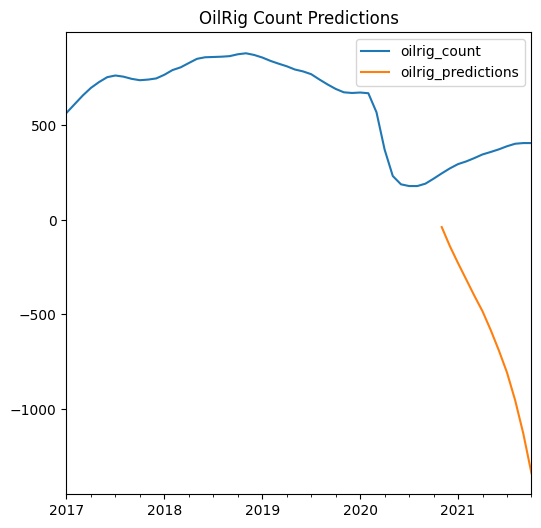

In [ ]:
dfoil.loc['2017':]['oilrig_count'].plot(legend=True,title='OilRig Count Predictions')
testoil_predictions['oilrig_predictions'].plot(legend=True)

Mean Squared Error (MSE): 4196828996.6404395
Mean Absolute Error (MAE): 24954.631922984878
Root Mean Squared Error (RMSE): 64782.937542538464
Mean Absolute Percentage Error (MAPE): 28.31524111255864
Coefficient of determination (R2): -103.98487498810923


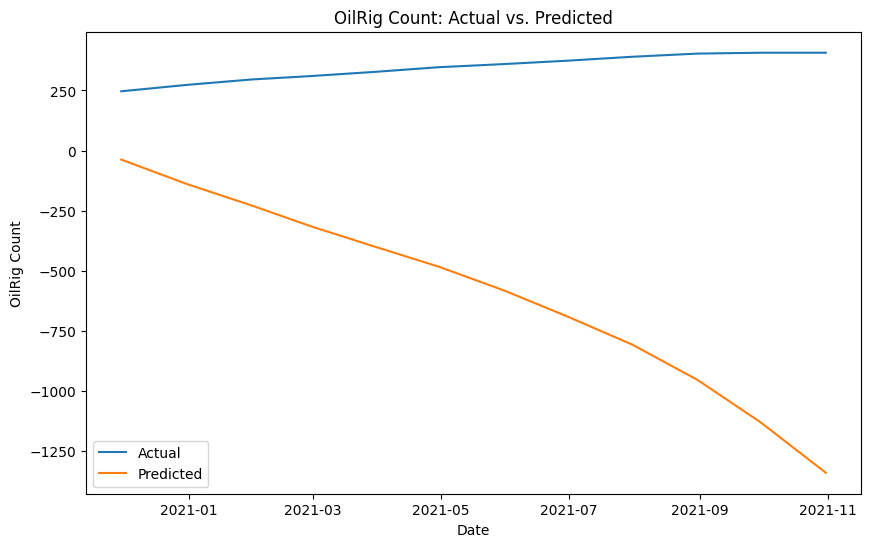

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# Calculate metrics
mse = mean_squared_error(test_oil, testoil_predictions)
mae = mean_absolute_error(test_oil, testoil_predictions)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((test_oil - testoil_predictions) / test_oil)) * 100
r2 = r2_score(test_oil, testoil_predictions)

# Print metrics
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Percentage Error (MAPE):", mape)
print("Coefficient of determination (R2):", r2)

# Plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.plot(test_oil.index, test_oil['oilrig_count'], label='Actual')
plt.plot(testoil_predictions.index, testoil_predictions['oilrig_predictions'], label='Predicted')
plt.title('OilRig Count: Actual vs. Predicted')
plt.xlabel('Date')
plt.ylabel('OilRig Count')
plt.legend()
plt.show()


**Arima Model**

In [ ]:
!pip install pmdarima

In [ ]:
from statsmodels.tsa.arima.model import ARIMA,ARIMAResults
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tools.eval_measures import rmse, mse, meanabs
from sklearn.model_selection import TimeSeriesSplit
import time
from pmdarima import auto_arima
from pylab import rcParams

In [ ]:
rcParams['figure.figsize'] = 6,6

In [ ]:
nobs = 12

In [ ]:
stepwise_fit = auto_arima(dfoil['oilrig_count'], start_p=0, start_q=0,
                          max_p=6, max_q=3, m=nobs,
                          seasonal=True,
                          d=None, trace=True,
                          error_action='ignore',
                          suppress_warnings=True,
                          stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=2965.143, Time=0.39 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2964.110, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=2595.587, Time=0.38 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.68 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=2962.119, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=2595.900, Time=0.08 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=2596.893, Time=1.10 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=2597.400, Time=0.68 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=2595.435, Time=0.54 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=2597.316, Time=1.69 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=2599.051, Time=1.42 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=2963.810, Time=0.25 sec
 ARIMA(2,1,0)(0,0,1)[12] intercept   : AIC=2496.812, Time=0.56 sec
 ARIMA(2,1,0)(0,0,0)[12] intercept   : AIC=2498.442, Time=0.17 sec
 ARIMA(2,1,0)(1,0,1)[12]

In [ ]:
train = dfoil.iloc[:len(dfoil)-nobs]
test = dfoil.iloc[len(dfoil)-nobs:]

In [ ]:
oil_model = ARIMA(train['oilrig_count'],order=(3,1,1))
oil_results = oil_model.fit()

In [ ]:
start=len(train)
end=len(train)+len(test)-1
oil_predictions = oil_results.predict(start=start, end=end, dynamic=False, typ='levels').rename('Oil Rig Count ARIMA(3,1,1) Predictions')

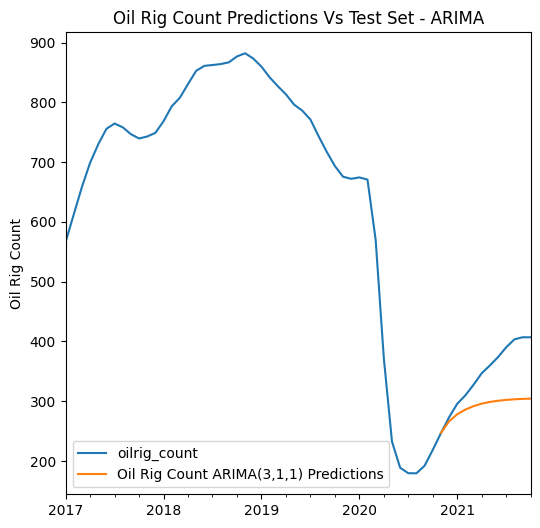

In [ ]:
title = 'Oil Rig Count Predictions Vs Test Set - ARIMA'
ylabel='Oil Rig Count'
xlabel=''

ax = dfoil['oilrig_count'].loc['2017':].plot(legend=True,title=title)
oil_predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

In [ ]:
RMSE1 = rmse(dfoil['oilrig_count'].loc[test.index.min():],oil_predictions)
MSE1 = mse(dfoil['oilrig_count'].loc[test.index.min():],oil_predictions)
MAE1 = meanabs(dfoil['oilrig_count'].loc[test.index.min():],oil_predictions)
r2 = r2_score(dfoil['oilrig_count'].loc[test.index.min():], oil_predictions)
print(f"""Oil Rig ARIMA(3,1,1) RMSE: {RMSE1:.3f}
Oil Rig ARIMA(3,1,1) MSE: {MSE1:.3f}
Oil Rig ARIMA(3,1,1) MAE: {MAE1:.3f}
Oil Rig ARIMA(3,1,1) R2: {r2:.3f}\n
Oil Rig Mean Value: {dfoil['oilrig_count'][-nobs:].mean():.3f}
Oil Rig std Value: {dfoil['oilrig_count'][-nobs:].std():.3f}
Oil Rig Percent Change: {RMSE1/dfoil['oilrig_count'][-nobs:].mean()*100:.3f}%
""")

Oil Rig ARIMA(3,1,1) RMSE: 66.322
Oil Rig ARIMA(3,1,1) MSE: 4398.668
Oil Rig ARIMA(3,1,1) MAE: 55.252
Oil Rig ARIMA(3,1,1) R2: -0.598

Oil Rig Mean Value: 345.055
Oil Rig std Value: 54.791
Oil Rig Percent Change: 19.221%



In [ ]:
startTime = time.time()
oil_model = ARIMA(dfoil['oilrig_count'],order=(3,1,1))
oil_results = oil_model.fit()

In [ ]:
start=len(dfoil)
end=len(dfoil)+nobs
oil_predictions = oil_results.predict(start=start, end=end, dynamic=False, typ='levels').rename('Oil Rig Count ARIMA(3,1,1) Predictions')
executionTime = (time.time() - startTime)
print('Execution time in seconds: ' + str(executionTime))

Execution time in seconds: 0.19125890731811523


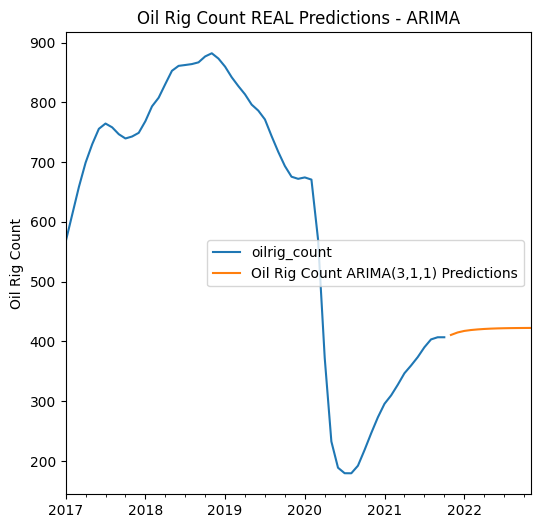

In [ ]:
title = 'Oil Rig Count REAL Predictions - ARIMA'
ylabel='Oil Rig Count'
xlabel=''

ax = dfoil['oilrig_count'].loc['2017':].plot(legend=True,title=title)
oil_predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

**Varma Model Implementationt**

In [ ]:
from statsmodels.tsa.statespace.varmax import VARMAX, VARMAXResults
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from statsmodels.tools.eval_measures import rmse, mse, meanabs
from sklearn.model_selection import TimeSeriesSplit
import time
from pylab import rcParams

In [ ]:
dfoil_transformed = dfoil.diff().diff()
dfoil_transformed = dfoil_transformed.dropna()
dfoil_transformed.head()

,oilrig_count,oil_price,oilconsumption,oilproduction,oilstorage
1997-03-31,-7.056452,1.312871,481.072565,-72.177714,-6540.096313
1997-04-30,-8.104032,0.182258,-152.485198,92.726362,2345.221198
1997-05-31,10.490323,2.344355,424.190083,-43.429157,-3579.112903
1997-06-30,-9.318280,-2.697634,-138.891237,-14.576469,-2234.476344
1997-07-31,3.823656,1.878333,-50.252335,-5.380888,-9928.515054


In [ ]:
nobs=12
train, test = dfoil_transformed[0:-nobs], dfoil_transformed[-nobs:]

In [ ]:
oil_model = VARMAX(train, order=(2,2), trend='ctt')
oil_results = oil_model.fit(maxiter=1000, disp=True)
oil_results.summary()

Dep. Variable:,"['oilrig_count', 'oil_price', 'oilconsumption', 'oilproduction', 'oilstorage']",No. Observations:,284
Model:,"VARMA(2,2)",Log Likelihood,-9057.796
,+ intercept,AIC,18375.592
Date:,"Sun, 28 Apr 2024",BIC,18849.959
Time:,18:04:49,HQIC,18565.776
Sample:,03-31-1997,,
,- 10-31-2020,,
Covariance Type:,opg,,
Ljung-Box (L1) (Q):,"0.83, 0.34, 4.51, 0.50, 1.34",Jarque-Bera (JB):,"1895.97, 37.73, 803.86, 953.23, 0.11"
Prob(Q):,"0.36, 0.56, 0.03, 0.48, 0.25",Prob(JB):,"0.00, 0.00, 0.00, 0.00, 0.95"
Heteroskedasticity (H):,"4.99, 3.84, 2.31, 2.58, 1.97",Skew:,"-1.68, -0.14, -1.08, 0.03, 0.03"


In [ ]:
dfoil_forecast = oil_results.forecast(nobs)
dfoil_forecast

,oilrig_count,oil_price,oilconsumption,oilproduction,oilstorage
2020-11-30,-4.280394,-1.435711,-695.481553,-182.799444,-7846.901444
2020-12-31,-13.202206,-0.066545,-60.069108,139.041036,-2688.598486
2021-01-31,-2.123777,1.368484,264.122033,-56.779543,4217.805805
2021-02-28,4.743731,-0.386538,-66.416784,-4.966729,259.075275
2021-03-31,4.193703,0.064971,113.294082,12.344146,-1984.705119
2021-04-30,1.370701,-0.352358,15.953364,-12.571195,-932.333185
2021-05-31,-0.750705,-0.350336,-1.390188,1.909956,-405.332549
2021-06-30,-0.404127,0.093711,53.540804,-7.021171,-247.747746
2021-07-31,0.831223,-0.001021,36.703984,-5.345431,-382.825801
2021-08-31,1.371113,-0.082420,42.388808,-1.618196,-563.186966


In [ ]:
dfoil_forecast['oilrig_count1d'] = (dfoil['oilrig_count'].iloc[-nobs-1]-dfoil['oilrig_count'].iloc[-nobs-2])+dfoil_forecast['oilrig_count'].cumsum()
dfoil_forecast['oilrig_forecast'] = dfoil['oilrig_count'].iloc[-nobs-1] + dfoil_forecast['oilrig_count1d'].cumsum()

<Axes: title={'center': 'Oil Rig Count Prediction: FORECAST vs TEST Set - VARMA'}>

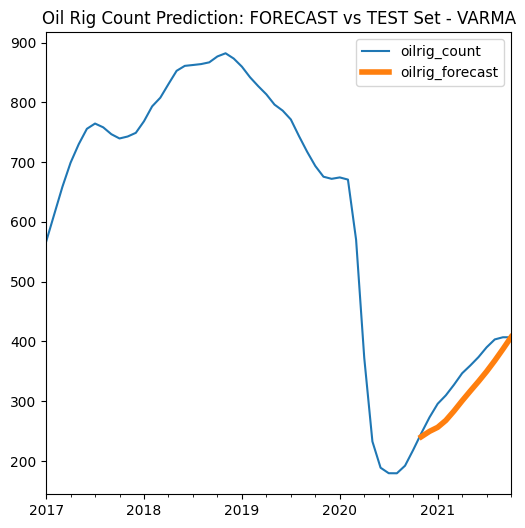

In [ ]:
dfoil['oilrig_count'].loc['2017':].plot(legend=True)
dfoil_forecast['oilrig_forecast'].plot(legend=True,linewidth=4,title='Oil Rig Count Prediction: FORECAST vs TEST Set - VARMA')

In [ ]:
RMSE1 = rmse(dfoil['oilrig_count'].loc[test.index.min():],dfoil_forecast['oilrig_forecast'])
MSE1 = mse(dfoil['oilrig_count'].loc[test.index.min():],dfoil_forecast['oilrig_forecast'])
MAE1 = meanabs(dfoil['oilrig_count'].loc[test.index.min():],dfoil_forecast['oilrig_forecast'])
r2 = r2_score(dfoil['oilrig_count'].loc[test.index.min():],dfoil_forecast['oilrig_forecast'])
print(f"Oil Rig VARMA(2,2) RMSE: {RMSE1:.3f}")
print(f"Oil Rig VARMA(2,2) MSE: {MSE1:.3f}")
print(f"Oil Rig VARMA(2,2) MAE: {MAE1:.3f}\n")
print(f"Oil Rig VARMA(2,2) R2: {r2:.3f}\n")
print(f"Oil Rig Mean Value: {dfoil['oilrig_count'][-nobs:].mean():.3f}")
print(f"Oil Rig std Value: {dfoil['oilrig_count'][-nobs:].std():.3f}")
print(f"Oil Rig Percent Change: {RMSE1/dfoil['oilrig_count'][-nobs:].mean()*100:.3f}%")

Oil Rig VARMA(2,2) RMSE: 35.022
Oil Rig VARMA(2,2) MSE: 1226.545
Oil Rig VARMA(2,2) MAE: 31.681

Oil Rig VARMA(2,2) R2: 0.554

Oil Rig Mean Value: 345.055
Oil Rig std Value: 54.791
Oil Rig Percent Change: 10.150%


In [ ]:
oil_model = VARMAX(dfoil_transformed, order=(2,2), trend='ctt')
oil_results = oil_model.fit(maxiter=1000, disp=False)
dfoil_forecast = oil_results.forecast(nobs)
dfoil_forecast['oilrig_count1d'] = (dfoil['oilrig_count'].iloc[-1]-dfoil['oilrig_count'].iloc[-2])+dfoil_forecast['oilrig_count'].cumsum()
dfoil_forecast['oilrig_forecast'] = dfoil['oilrig_count'].iloc[-1] + dfoil_forecast['oilrig_count1d'].cumsum()

<Axes: title={'center': 'Oil Rig Count Prediction: REAL FORECAST - VARMA'}>

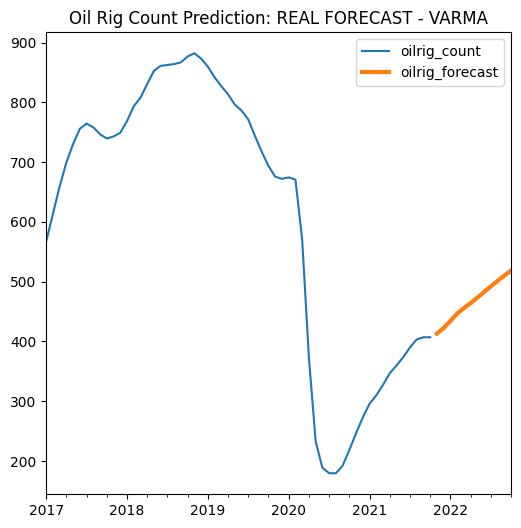

In [ ]:
dfoil['oilrig_count'].loc['2017':].plot(legend=True)
dfoil_forecast['oilrig_forecast'].plot(legend=True,linewidth=3,title='Oil Rig Count Prediction: REAL FORECAST - VARMA')

**EWMA**

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
import datetime
from pylab import rcParams
from statsmodels.tsa.holtwinters import SimpleExpSmoothing #for single exponential smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing #for double exponential smoothing
from statsmodels.tools.eval_measures import rmse, mse, meanabs
from sklearn.model_selection import TimeSeriesSplit
import time
from pylab import rcParams


In [ ]:
oilmodel_exp = ExponentialSmoothing(train_oil['oilrig_count'],trend='add',seasonal='mul',seasonal_periods=nobs)
oilmodel_exp = oilmodel_exp.fit()

In [ ]:
dfoil_forecast = oilmodel_exp.forecast(nobs)

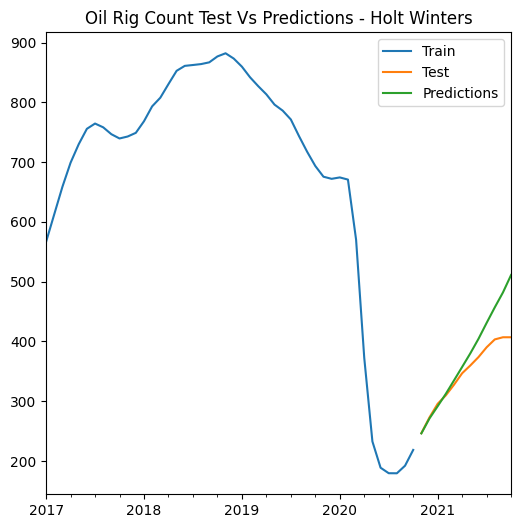

In [ ]:
train_oil['oilrig_count'].loc['2017':].plot(legend=True,label='Train',title='Oil Rig Count Test Vs Predictions - Holt Winters')
test_oil['oilrig_count'].plot(legend=True,label='Test')
dfoil_forecast.plot(legend=True,label='Predictions');

In [ ]:
RMSE1 = rmse(dfoil['oilrig_count'].loc[test_oil.index.min():],dfoil_forecast)
MSE1 = mse(dfoil['oilrig_count'].loc[test_oil.index.min():],dfoil_forecast)
MAE1 = meanabs(dfoil['oilrig_count'].loc[test_oil.index.min():],dfoil_forecast)
r2 = r2_score(dfoil['oilrig_count'].loc[test_oil.index.min():],dfoil_forecast)
print(f"""Oil Rig VAR(4) RMSE: {RMSE1:.3f}
Oil Rig VAR(4) MSE: {MSE1:.3f}
Oil Rig VAR(4) MAE: {MAE1:.3f}
Oil Rig VAR(4) R2: {r2:.3f}    \n
Oil Rig Mean Value: {dfoil['oilrig_count'][-nobs:].mean():.3f}
Oil Rig std Value: {dfoil['oilrig_count'][-nobs:].std():.3f}
Oil Rig Percent Change: {RMSE1/dfoil['oilrig_count'][-nobs:].mean()*100:.3f}%""")

Oil Rig VAR(4) RMSE: 43.342
Oil Rig VAR(4) MSE: 1878.522
Oil Rig VAR(4) MAE: 29.241
Oil Rig VAR(4) R2: 0.317    

Oil Rig Mean Value: 345.055
Oil Rig std Value: 54.791
Oil Rig Percent Change: 12.561%


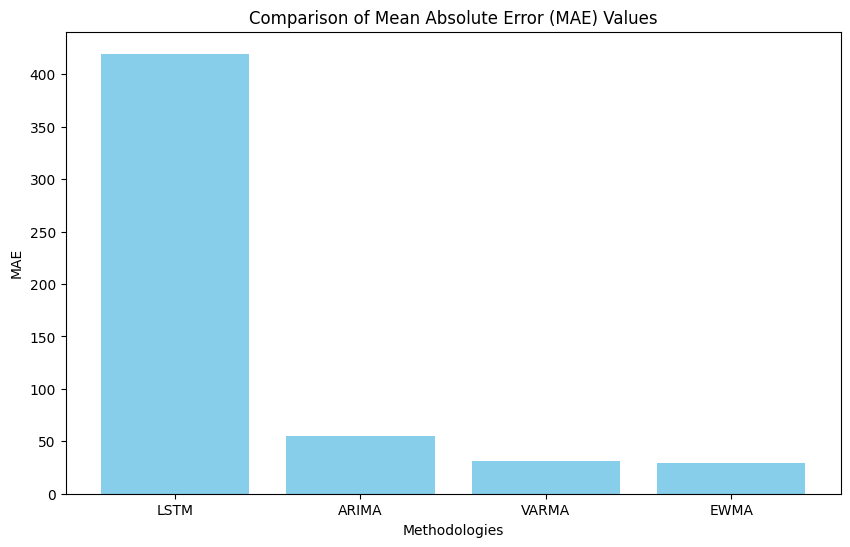

In [ ]:
import matplotlib.pyplot as plt

# Methodologies and corresponding MAE values
methodologies = ['LSTM', 'ARIMA', 'VARMA', 'EWMA']
mae_values = [419.6404395, 55.252, 31.681, 29.241]

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(methodologies, mae_values, color='skyblue')

# Adding labels and title
plt.title('Comparison of Mean Absolute Error (MAE) Values')
plt.xlabel('Methodologies')
plt.ylabel('MAE')

# Show plot
plt.show()
